In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from ranges.stripe_range import StripeRange
from hierarchical.kdtree import *
from baselines.baselines import linear_search
from hierarchical.index import HierarchicalIndex
from hierarchical.rtree_impl import *

In [2]:
def round_to_nearest_power_fraction(arr):
    """
    Round each element in arr to the nearest 1 / (2^i) for i = 1, 2, ..., such that 1/(2^i) < 1.
    Assumes all elements in arr are in (0,1).
    """
    powers = np.array([1 / (2 ** i) for i in range(1, 20)])  # Adjust range if needed
    arr = np.asarray(arr)

    def nearest_fraction(x):
        diffs = np.abs(powers - x)
        return powers[np.argmin(diffs)]

    return np.vectorize(nearest_fraction)(arr)

In [3]:
points = np.random.zipf(1.5, size=(20, 2))

query = StripeRange.sample_stripe(points, r=1 / 4, tolerance=0.001)

tree = RTree(max_entries=4, dimensions=2)
tree.insert_points(points)
# tree.traverse_tree()

Found!


In [4]:
tree.query(query)

[array([3, 1]), array([2, 1]), array([3, 1]), array([1, 1]), array([1, 1])]

In [5]:
points[linear_search(points, query)]

array([[3, 1],
       [2, 1],
       [1, 1],
       [3, 1],
       [1, 1]])

In [18]:
n = 10000
# dim = [2, 4, 8, 16, 32]
dim = [2]

results = {
    "hie_time": [],
    "linear_time": [],
    "r_time": [],
    "hie_recall": [],
    "r_recall": [],
    "dim": [],
    "n_points": [],
    "width": [],
}

for d in dim:
    print(f"dim: {d} : {dim}")
    points = np.random.zipf(1.5, size=(n, d))

    print("Building index...")
    index = HierarchicalIndex(points, decay=4)
    index.build_index()
    index.find_coverage()
    index.find_neighbor_stats()
    rtree = RTree(max_entries=4, dimensions=d)
    rtree.insert_points(points)

    # Query range
    for width in [
        1 / 2,
        1 / 4,
        1 / 8,
        1 / 16,
        1 / 32,
        1 / 64,
        1 / 128,
        1 / 256,
        1 / 512,
    ]:
        for i in range(5):
            print(f"\t sample {i+1} out of {5}")
            query = StripeRange.sample_stripe(points, r=width, tolerance=0.001)

            print("Querying...")
            start = time.time()
            linear_results = linear_search(points, query)
            linear_time = time.time() - start

            start = time.time()
            hie_results = index.query(query)
            hie_time = time.time() - start
            hie_recall = (
                len(hie_results) / len(linear_results)
                if len(linear_results) > 0
                else 1.0
            )

            start = time.time()
            r_results = rtree.query(query)
            r_time = time.time() - start
            r_recall = (
                len(r_results) / len(linear_results) if len(linear_results) > 0 else 1.0
            )

            results["hie_time"].append(hie_time)
            results["linear_time"].append(linear_time)
            results["r_time"].append(r_time)
            results["hie_recall"].append(hie_recall)
            results["r_recall"].append(r_recall)
            results["dim"].append(d)
            results["n_points"].append(n)
            results["width"].append(len(linear_results))

dim: 2 : [2]
Building index...
L: 7


/home/mohsen/venv/lib/python3.12/site-packages/miniball.py:46: RuntimeWarning: invalid value encountered in divide
  U /= B[:, None]


	 sample 1 out of 5
Found!
Querying...
candidates:  5034 all:  10000
	 sample 2 out of 5
Found!
Querying...
candidates:  5053 all:  10000
	 sample 3 out of 5
Found!
Querying...
candidates:  5093 all:  10000
	 sample 4 out of 5
Found!
Querying...
candidates:  5048 all:  10000
	 sample 5 out of 5
Found!
Querying...
candidates:  5049 all:  10000
	 sample 1 out of 5
Found!
Querying...
candidates:  2574 all:  10000
	 sample 2 out of 5
Found!
Querying...
candidates:  2760 all:  10000
	 sample 3 out of 5
Found!
Querying...
candidates:  2520 all:  10000
	 sample 4 out of 5
Found!
Querying...
candidates:  2604 all:  10000
	 sample 5 out of 5
Found!
Querying...
candidates:  2572 all:  10000
	 sample 1 out of 5
Found!
Querying...
candidates:  1290 all:  10000
	 sample 2 out of 5
Found!
Querying...
candidates:  1272 all:  10000
	 sample 3 out of 5
Found!
Querying...
candidates:  1295 all:  10000
	 sample 4 out of 5
Found!
Querying...
candidates:  1302 all:  10000
	 sample 5 out of 5
Found!
Queryin

In [19]:
df = pd.DataFrame(results)
df.head()

,hie_time,linear_time,r_time,hie_recall,r_recall,dim,n_points,width
0,0.006611,0.006877,0.052552,1.000000,0.982432,2,10000,5009
1,0.006059,0.006913,0.053705,1.000000,0.988221,2,10000,5009
2,0.005888,0.006888,0.052330,0.999601,0.979633,2,10000,5008
3,0.005723,0.006922,0.051133,1.000000,0.973049,2,10000,5009
4,0.005566,0.006864,0.050707,1.000000,0.973448,2,10000,5009


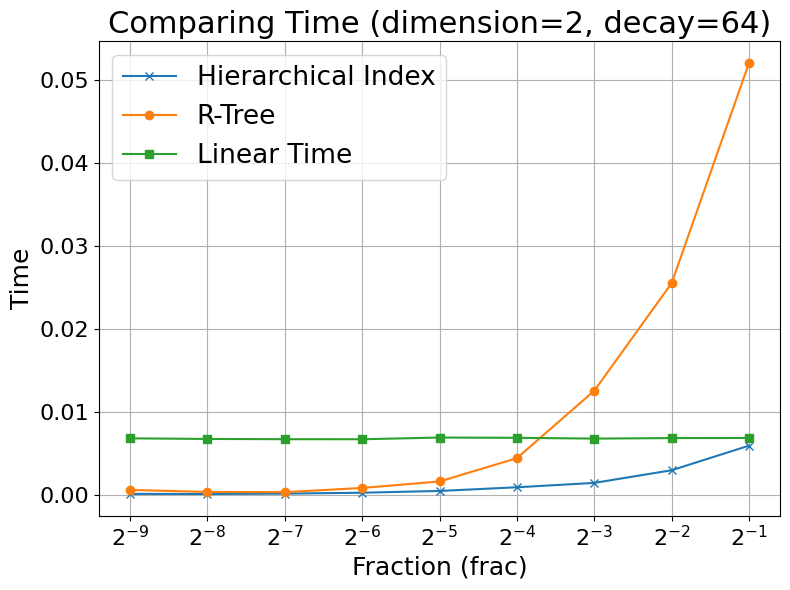

In [ ]:
# d = 2
# df = results[results["dim"] == d]
df["frac"] = round_to_nearest_power_fraction(df["width"] / df["n_points"])

# Group by frac and compute mean times
grouped = df.groupby("frac").mean(numeric_only=True)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(grouped.index, grouped["hie_time"], marker="x", label="Hierarchical Index")
plt.plot(grouped.index, grouped["r_time"], marker="o", label="R-Tree")
plt.plot(grouped.index, grouped["linear_time"], marker="s", label="Linear Time")

# Formatting
plt.xlabel("Fraction (frac)", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.title(f"Comparing Time (dimension={d}, decay=64)", fontsize=22)
plt.legend(fontsize=19)
plt.grid(True)
plt.xscale("log", base=2)
plt.xticks(fontsize=16)  # You can adjust the number as needed
plt.yticks(fontsize=16)
plt.tight_layout()
# plt.savefig(f'zipf_with_width_dim_{d}_decay=8.png')
plt.show()